In [1]:
library(dplyr)
library(readr)
library(tidyr)
library(stringr)
library(ggplot2)
library(lubridate)
library(survival)
library(survminer)

Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Warning message:
“package ‘survminer’ was built under R version 3.6.3”Loading required package: ggpubr
Warning message:
“package ‘ggpubr’ was built under R version 3.6.3”

In [2]:
##############################
# Creation of Financial Series
##############################
monsanc <- read_csv("monsanc.csv") %>%
  select(person_id, case_filed_date, sentence_date,filed_county,
         case_mkey, pubdef, charge_offense, charge_degree, 
         priors, prob_days, conf_days, race, gender,
         name_full, birth_year, birth_date, trial_flag, adj) %>%
  mutate(sentence_date = as.character(format(sentence_date, "%Y-%m" )))

#MNCIS Financial - originally at transaction level
mncis <- read_delim("MNCIS_Financial.txt", delim = "|", na = "NULL",
                    col_types = list(col_double(), col_double(), 
                                     col_double(), col_character(), 
                                     col_character(), col_double(), 
                                     col_datetime(), col_character(),
                                     col_character(), col_double(),
                                     col_double(), col_double(),
                                     col_double(), col_double(),
                                     col_double(), col_double())) %>%
  slice(-dim(.)[1])
str(mncis)

#Merging reduced category variable
mncis.bridge <- read_csv(file = "mncis_fees.csv")
mncis$Fee_Type_Category_Desc <- str_trim(mncis$Fee_Type_Category_Desc, side = "both") #trimming wtspace
mncis$Fee_Type_Desc <- str_trim(mncis$Fee_Type_Desc, side = "both") #trimming wtspace

mncis <- mncis %>% left_join(mncis.bridge, 
                             by = c("Fee_Type_Desc"="fee_type_desc", "Fee_Type_Category_Desc"="fee_type_category_desc"))

#mncis time series
#mncis financial transaction date for ordered IS the sentence date
mncis.time <- mncis %>%
  select(Case_Mkey, new_cat, 
         Financial_Transaction_Detail_Charge_Amount, 
         Financial_Transaction_Detail_Payment_Amount,
         Financial_Transaction_Detail_Credit_Amount,
         Financial_Transaction_Date) %>%
  rename(mncis_ordered = Financial_Transaction_Detail_Charge_Amount,
         mncis_collected = Financial_Transaction_Detail_Payment_Amount,
         mncis_credit = Financial_Transaction_Detail_Credit_Amount,
         type = new_cat) %>%
  mutate(date = format(as.Date(Financial_Transaction_Date), "%Y-%m")) %>% 
  filter(type!="BAIL" & type!="UNK" & type!="OTHER") %>%
  mutate(mncis_ordered_adj = mncis_ordered-mncis_credit) %>%
  mutate(mncis_ordered_adj = ifelse(mncis_ordered_adj < 0, 0, mncis_ordered_adj),
         mncis_collected = ifelse(mncis_collected < 0, 0, mncis_collected)) %>%
  select(-type, -mncis_ordered) %>%
  group_by(Case_Mkey, date) %>%
  summarise(mncis_ordered = sum(mncis_ordered_adj, na.rm = T),
            mncis_collected = sum(mncis_collected, na.rm=T)) %>%
  arrange(Case_Mkey, date)

rm(mncis.bridge, mncis)


#vibes - made to match mncis.time
#VIBES financial 
vibes <- read_delim("VIBES_Financial.txt", delim = "|", na = "NULL") %>% 
  slice(-dim(.)[1]) 

#vibes time series
#vibes does not have sentence date, must merge in from sentence
vibes.clean <- vibes %>% 
  select(Incident_ID,  
         Total_Assessments, 
         Total_Payments,
         Payment_Date) %>%
  mutate(vibes_ordered = ifelse(Total_Assessments < 0, 0, Total_Assessments),
         vibes_collected = ifelse(Total_Payments < 0, 0, Total_Payments),
         payment_date = format(Payment_Date, "%Y-%m-%d")) %>%
  select(-Payment_Date, -Total_Assessments, -Total_Payments) %>%
  mutate(vibes_ordered = ifelse(is.na(vibes_ordered), 0, vibes_ordered),
         vibes_collected = ifelse(is.na(vibes_collected), 0, vibes_collected))

#merge vibes bridge to vibes, then select unique identifiers merge
vibes.bridge <- read_delim("VIBES_Bridge.txt",  delim = "|", na = "NULL") %>%
  slice(-dim(.)[1]) 

vibes.merge <- vibes %>% left_join(vibes.bridge, by = c("Incident_ID" = "INCIDENT_ID")) %>%
  mutate(county = ifelse(CNTY_CODE==62, "Ramsey County", "Hennepin County")) %>%
  select(Case_Mkey, county, Incident_ID) %>% distinct(Incident_ID, .keep_all = T)

vibes.clean <- vibes.clean %>% left_join(vibes.merge, by = "Incident_ID")

#merge in sentence date from person.case object (have to merge by Case_Mkey and county)
vibes.clean <- vibes.clean %>% 
  left_join(monsanc, by = c("county"="filed_county", "Case_Mkey"="case_mkey")) %>%
  select(Incident_ID, Case_Mkey, vibes_ordered, vibes_collected, sentence_date, payment_date, county) 

#the following sets date to the respective event date, then appends and summarizes over case and date
vibes.ordered <- vibes.clean %>% 
  select(Incident_ID, vibes_ordered, sentence_date) %>%
  rename(date = sentence_date)

vibes.payed <- vibes.clean %>% select(Incident_ID, vibes_collected, payment_date) %>%
  mutate(date = format(as.Date(payment_date), "%Y-%m")) %>% 
  select(-payment_date)

vibes.time <- vibes.ordered %>% bind_rows(vibes.payed) %>%
  group_by(Incident_ID, date) %>%
  summarize(vibes_ordered = sum(vibes_ordered, na.rm=T),
            vibes_collected = sum(vibes_collected, na.rm=T)) %>%
  arrange(Incident_ID, date) %>%
  filter(!is.na(date)) #these are due to missing sentence_dates for cases in vibes series

vibes.time <- vibes.time %>% left_join(vibes.merge, by = "Incident_ID")  

#merging monsanc to mncis and vibes series (have to do merges separately before appending due to different id's)
mncis.person <- mncis.time %>% 
  left_join(monsanc, by = c("Case_Mkey"="case_mkey")) %>% 
  rename(ordered = mncis_ordered, collected = mncis_collected, county = filed_county) 

vibes.person <- vibes.time %>% 
  left_join(monsanc, by = c("county"="filed_county", "Case_Mkey"="case_mkey")) %>%
  rename(ordered = vibes_ordered, collected = vibes_collected) %>% ungroup() %>% select(-Incident_ID) 

#combining - case-level financial series
fin.series <- mncis.person %>% bind_rows(vibes.person) %>% arrange(person_id, date)

#create case count (data already arranged by date)
count <- fin.series %>% select(person_id, Case_Mkey) %>% distinct(person_id,Case_Mkey) %>%
  group_by(person_id) %>% mutate(count = row_number()) 

fin.series <- fin.series %>% left_join(count, by = c("person_id", "Case_Mkey"))

rm(list = ls()[!ls() %in% c("fin.series", "monsanc")])

#adjusting amounts to January 2018, other recodes
fin.series <- fin.series %>%
  mutate(ordered = ordered*adj, 
         collected = collected*adj, 
         prob_days=ifelse(is.na(prob_days), 0, prob_days),
         sentence_year = as.Date(sentence_date, format = "%Y")) %>%
  ungroup()

Parsed with column specification:
cols(
  .default = col_double(),
  current_case_number = col_character(),
  case_filed_date = col_datetime(format = ""),
  case_first_final_disposition_date = col_datetime(format = ""),
  current_case_status_desc = col_character(),
  current_case_status_date = col_datetime(format = ""),
  filed_district = col_character(),
  filed_county = col_character(),
  judge_full_name = col_character(),
  fin_source = col_character(),
  pubdef = col_character(),
  attorney = col_character(),
  charge_offense = col_character(),
  dui_tag = col_character(),
  reduce = col_character(),
  sentence_date = col_datetime(format = ""),
  gender = col_character(),
  address_state = col_character(),
  race = col_character(),
  birth_date = col_date(format = ""),
  name_full = col_character()
  # ... with 18 more columns
)
See spec(...) for full column specifications.
Warning message:
“2 parsing failures.
     row       col   expected                     actual               

tibble [80,480,421 × 16] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Case_Mkey                                       : num [1:80480421] 1399 1399 1399 1399 1399 ...
 $ Charge_Mkey                                     : num [1:80480421] 272792 272792 272792 272792 272792 ...
 $ Fee_ID                                          : num [1:80480421] 9560401 9560401 9560401 9560402 9560402 ...
 $ Fee_Type_Desc                                   : chr [1:80480421] "Crim/Traffic Surcharge 2003" "Crim/Traffic Surcharge 2003" "Crim/Traffic Surcharge 2003" "Law Library Criminal" ...
 $ Fee_Type_Category_Desc                          : chr [1:80480421] "Surcharges - Criminal" "Surcharges - Criminal" "Surcharges - Criminal" "Law  Library Fees - Criminal" ...
 $ Transaction_ID                                  : num [1:80480421] 10227691 10249547 10389607 10227691 10249547 ...
 $ Financial_Transaction_Date                      : POSIXct[1:80480421], format: "2004-02-10 00:00:00" "2004-02-10 00:00:00" ...


Parsed with column specification:
cols(
  fee_type_desc = col_character(),
  fee_type_category_desc = col_character(),
  new_cat = col_character()
)
Parsed with column specification:
cols(
  Incident_ID = col_double(),
  CNTY_CODE = col_double(),
  Case_Filed_Date = col_datetime(format = ""),
  Filed_Year = col_double(),
  Imposed_Fee_ID = col_double(),
  FEE_CODE = col_character(),
  FEE_DESC = col_character(),
  FEE_CATEGORY = col_character(),
  Total_Assessments = col_double(),
  Total_Payments = col_double(),
  Payment_Trans_ID = col_double(),
  Payment_Date = col_datetime(format = ""),
  Payment_Amount = col_double()
)
Warning message:
“2 parsing failures.
     row         col   expected                     actual                  file
11793465 Incident_ID a double   (11793464 row(s) affected) 'VIBES_Financial.txt'
11793465 NA          13 columns 1 columns                  'VIBES_Financial.txt'
”Parsed with column specification:
cols(
  Case_Mkey = col_double(),
  INCIDENT_ID = co

In [3]:
############################
# Event History Framework
############################

#keep only first case per person ID and date of second case if one exists
#create dataset of just first date of second case
event <- fin.series %>% filter(count==2) %>% select(person_id, Case_Mkey, date) %>%
  distinct(Case_Mkey, .keep_all = T) %>% rename(event_date = date, event_case_mkey = Case_Mkey)

#reduce series to just first offense
eha <- fin.series %>% filter(count==1)

#merge event case_mkey and date back to series
eha <- eha %>% left_join(event, by = "person_id") %>% select(-count)

#set.seed(1919)
#eha <- eha %>% filter(person_id %in% sample(eha$person_id, 10000))

#CLOCK
#analysis period start: 2010-01-01
#clock start: date (sentencing date)
#event date: date of case_filed date of second case, or 12/31/15 if no second case
#clock end: 2015-12-31

#mutate date var and drop pre-2010 series (vibes missings)
#fill in event dates
#create binary event indicator
#alter event indicator and end date to reflect end of clock
#drop spells (e.g. payments after recid.) made after end_date
eha <- eha %>% 
  mutate(date = as.Date(paste(date, 01, sep="-"), format = "%Y-%m-%d"),
         event_date = as.Date(paste(event_date, 01, sep="-"), format = "%Y-%m-%d"),
         sentence_date = as.Date(paste(sentence_date, 01, sep="-"), format = "%Y-%m-%d")) %>%
  mutate(event = if_else(is.na(event_date)==T, 0, 1), #event indicator
         end_date = if_else(is.na(event_date)==T, as.Date("2015-12-31"), event_date), #fill censored dates
         event = if_else(end_date > as.Date("2015-12-31"), 0, event), #censor cases that recidivate after clock end
         end_date = if_else(end_date > as.Date("2015-12-31"), as.Date("2015-12-31"), end_date)) %>%
  filter(date <= end_date) #keep cases before end_date

Call:
coxph(formula = Surv(time = enter, time2 = exit, event = event) ~ 
    lfo_debt, data = eha.complete)

  n= 113154346, number of events= 1302418 

              coef exp(coef)  se(coef)     z Pr(>|z|)  
lfo_debt 4.207e-06 1.000e+00 1.735e-06 2.425   0.0153 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         exp(coef) exp(-coef) lower .95 upper .95
lfo_debt         1          1         1         1

Concordance= 0.539  (se = 0 )
Likelihood ratio test= 4.46  on 1 df,   p=0.03
Wald test            = 5.88  on 1 df,   p=0.02
Score (logrank) test = 5.8  on 1 df,   p=0.02


Call:
coxph(formula = Surv(time = enter, time2 = exit, event = event) ~ 
    lfo_debt + race + gender + age, data = eha.complete)

  n= 113154346, number of events= 1302418 

                          coef  exp(coef)   se(coef)        z Pr(>|z|)    
lfo_debt            -7.618e-05  9.999e-01  8.422e-06   -9.045  < 2e-16 ***
raceBlack            3.061e-01  1.358e+00  7.070e-03   43.295  < 2e-16 ***
raceHawaiianPacific -3.492e-02  9.657e-01  2.655e-02   -1.315 0.188453    
raceHispanic        -1.151e-01  8.913e-01  7.871e-03  -14.617  < 2e-16 ***
raceIndian           1.706e-01  1.186e+00  9.495e-03   17.971  < 2e-16 ***
raceMultiracial      3.245e-01  1.383e+00  2.546e-02   12.743  < 2e-16 ***
raceOther            1.877e-02  1.019e+00  1.352e-02    1.389 0.164919    
raceRefused          5.016e-02  1.051e+00  1.341e-02    3.741 0.000183 ***
raceUnavailable     -3.110e-01  7.327e-01  6.882e-03  -45.194  < 2e-16 ***
raceUnknown         -6.510e-01  5.215e-01  6.420e-03 -101.391  < 2e-16 ***


Call:
coxph(formula = Surv(time = enter, time2 = exit, event = event) ~ 
    lfo_debt + race + gender + age + charge_offense + charge_degree, 
    data = eha.complete)

  n= 113154346, number of events= 1302418 

                                     coef  exp(coef)   se(coef)        z
lfo_debt                       -2.144e-05  1.000e+00  5.247e-06   -4.087
raceBlack                       3.342e-01  1.397e+00  7.084e-03   47.183
raceHawaiianPacific            -4.395e-03  9.956e-01  2.656e-02   -0.166
raceHispanic                   -7.326e-02  9.294e-01  7.892e-03   -9.284
raceIndian                      2.376e-01  1.268e+00  9.522e-03   24.954
raceMultiracial                 3.524e-01  1.422e+00  2.547e-02   13.838
raceOther                       3.523e-02  1.036e+00  1.352e-02    2.605
raceRefused                     6.607e-02  1.068e+00  1.341e-02    4.928
raceUnavailable                -3.308e-01  7.183e-01  6.888e-03  -48.029
raceUnknown                    -6.899e-01  5.016e-01  6.4

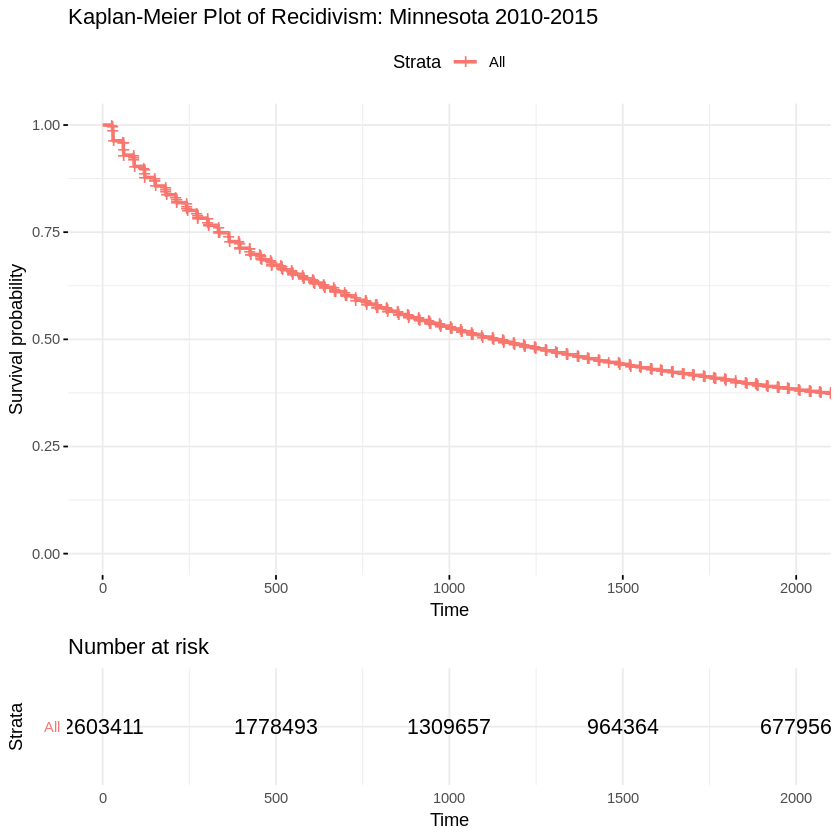

In [4]:
#expand series by month, fill NAs, 
eha.complete <- eha %>% group_by(person_id) %>%
  complete(date = seq.Date(min(date), max(end_date), by = "month")) %>%
  ungroup(person_id) %>%
  fill(Case_Mkey, case_filed_date, sentence_date, county, event_case_mkey, event_date, end_date,
       person_id, birth_date, birth_year, pubdef, charge_offense, charge_degree, sentence_date,
       trial_flag, adj, prob_days, priors, race, gender, ordered, sentence_year, conf_days, 
       name_full) %>%
  mutate(ordered = replace_na(ordered, 0), collected = replace_na(collected, 0),
         event = replace_na(event, 0)) %>% group_by(person_id) %>% 
  mutate(event = ifelse(sum(event, na.rm = T)>0 & date==event_date, 1, 0))

rm(fin.series, eha, event)

#create running vars
eha.complete <- eha.complete %>% 
  select(person_id, Case_Mkey, county, date, end_date, sentence_date,
         event, birth_date, 
         ordered, collected, 
         race,gender,charge_offense,charge_degree) %>%
  group_by(person_id) %>% 
  mutate(cum_order = cumsum(ordered),
         cum_coll  = cumsum(collected), 
         age = (date-birth_date)/365.25) %>%
  ungroup() %>%
  mutate(lfo_debt = cum_order-cum_coll) %>%
  filter(lfo_debt >= 0) #negative debts?

eha.complete <- eha.complete %>% 
  mutate(interval_date = date %m+% months(1)-days(1), 
         enter = as.numeric(date)-as.numeric(sentence_date),
         exit = as.numeric(interval_date)-as.numeric(sentence_date))

eha.complete <- eha.complete %>%
  filter(enter >= 0) %>%#sentence_date entry errors
  mutate(lfo_debt = lfo_debt/100)

fit <- survfit(Surv(time = enter, time2 = exit, event = event) ~ 1, data = eha.complete)

ggsurvplot(fit, 
           risk.table = T, 
           conf.int = T, sas
           xlim = c(0,2000), 
           break.time.by = 500, 
           ggtheme = theme_minimal(), 
           title = "Kaplan-Meier Plot of Recidivism: Minnesota 2010-2015")

m1 <- coxph(Surv(time = enter, 
                 time2 = exit,
                 event = event)~lfo_debt,
            data = eha.complete)
summary(m1)

m2 <- coxph(Surv(time = enter, 
                 time2 = exit,
                 event = event)~lfo_debt+race+gender+age,
            data = eha.complete)
summary(m2) 

m3 <- coxph(Surv(time = enter, 
                 time2 = exit,
                 event = event)~lfo_debt+race+gender+age+charge_offense+charge_degree,
            data = eha.complete)
summary(m3)

In [5]:
############################################
# Fixed Effects Framework
##########################################

#pulling in case level data
monsanc <- read_csv("monsanc.csv") %>%
  select(person_id,case_mkey, case_filed_date, sentence_date, filed_county, adj) %>%
  mutate(sentence_date = as.character(format(sentence_date, "%Y-%m" )))

#list of cases
cases <- monsanc %>%
  select(person_id, case_filed_date, case_mkey) %>%
  rename(event_mkey = case_mkey, event_filed_date = case_filed_date)%>%s
  mutate(event_filed_date = substr(event_filed_date, 0, 7))

panel <- fin.series %>% 
  filter(case_filed_date >= "2010-01-01") %>%
  select(person_id, date, ordered, collected) %>%
  group_by(person_id, date) %>%
  summarize(ordered = sum(ordered, na.rm = T), 
            collected = sum(collected, na.rm = T)) %>%
  mutate(year = substr(date, 0, 4)) %>%
  left_join(cases, by = c("person_id", "date" = "event_filed_date")) %>%
  mutate(date = as.Date(paste(date, 01, sep="-"), format = "%Y-%m-%d")) %>%
  group_by(person_id) %>%
  complete(date = seq.Date(min(date), as.Date("2018-12-01"), by = "month")) %>%
  ungroup() %>%
  fill(person_id, year, adj) %>%
  mutate(ordered = replace_na(ordered, 0), collected = replace_na(collected, 0)) %>% 
  group_by(person_id) %>%
  mutate(cum_order = cumsum(ordered),
         cum_coll  = cumsum(collected)) %>%
  mutate(lfo_debt = cum_order-cum_coll,
         event = if_else(is.na(event_mkey), 0, 1))

fe <- clogit(event~lfo_debt+strata(person_id), 
             method = "efron",
             data = panel)
summary(fe)

Parsed with column specification:
cols(
  .default = col_double(),
  current_case_number = col_character(),
  case_filed_date = col_datetime(format = ""),
  case_first_final_disposition_date = col_datetime(format = ""),
  current_case_status_desc = col_character(),
  current_case_status_date = col_datetime(format = ""),
  filed_district = col_character(),
  filed_county = col_character(),
  judge_full_name = col_character(),
  fin_source = col_character(),
  pubdef = col_character(),
  attorney = col_character(),
  charge_offense = col_character(),
  dui_tag = col_character(),
  reduce = col_character(),
  sentence_date = col_datetime(format = ""),
  gender = col_character(),
  address_state = col_character(),
  race = col_character(),
  birth_date = col_date(format = ""),
  name_full = col_character()
  # ... with 18 more columns
)
See spec(...) for full column specifications.


ERROR: Error in eval(lhs, parent, parent): object 'fin.series' not found
